In [3]:
import sys
import numpy as np
import pandas as pd
import imageio
# from scipy.misc import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Bidirectional, LSTM
from keras.models import Model

# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization, Reshape
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from tensorflow.keras import initializers

# from keras.engine.topology import Layer
from tensorflow.keras.layers import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle
from sklearn import linear_model
from sklearn.utils import resample
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import numpy.random as rng
import torch
# import transformers
# from sentence_transformers import SentenceTransformer
# embedder = SentenceTransformer('bert-base-uncased')

import tensorflow_hub as hub
import tensorflow_text as text
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [4]:
from imblearn.ensemble import BalancedBaggingClassifier

# Reading Data

In [5]:
data = pd.read_csv("Data/emp_att_data.csv" , sep = "," , encoding = 'utf-8')

# Displaying Data

In [6]:
data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


# Numeric Distribution

In [7]:
numCols = data.select_dtypes([np.number]).columns
numCols

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

# Categorical Count Plot

In [8]:
objCols = data.select_dtypes(['object']).columns.drop("Attrition")
objCols

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

In [9]:
(data['MonthlyIncome'] <= 18000).value_counts()

True     1401
False      69
Name: MonthlyIncome, dtype: int64

In [10]:
data = data[(data['MonthlyIncome'] <= 180000)]
data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


## NumCompaniesWorked Outliers

In [11]:
(data['NumCompaniesWorked'] <= 8).value_counts()

True     1418
False      52
Name: NumCompaniesWorked, dtype: int64

In [12]:
data = data[(data['NumCompaniesWorked'] <= 8)]
data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,3,80,0,8,2,2,7,7,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


## TotalWorkingYears Outliers

In [13]:
(data['TotalWorkingYears'] <= 35).value_counts()

True     1406
False      12
Name: TotalWorkingYears, dtype: int64

In [14]:
data = data[(data['TotalWorkingYears'] <= 35)]
data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,3,80,0,8,2,2,7,7,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


## YearsInCurrentRole Outliers

In [15]:
(data['YearsInCurrentRole'] <= 17).value_counts()

True     1404
False       2
Name: YearsInCurrentRole, dtype: int64

In [16]:
data = data[(data['YearsInCurrentRole'] <= 17)]
data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,3,80,0,8,2,2,7,7,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


## YearsSinceLastPromotion Outliers

In [17]:
(data['YearsSinceLastPromotion'] <= 14).value_counts()

True     1393
False      11
Name: YearsSinceLastPromotion, dtype: int64

In [18]:
data = data[(data['YearsSinceLastPromotion'] <= 14)]
data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,3,80,0,8,2,2,7,7,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


## YearsWithCurrManager Outliers

In [19]:
(data['YearsWithCurrManager'] <= 15).value_counts()

True     1385
False       8
Name: YearsWithCurrManager, dtype: int64

In [20]:
data = data[(data['YearsWithCurrManager'] <= 15)]
data

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,3,80,0,8,2,2,7,7,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


## 85 rows were removed to handle outliers 5.78%

# Encode categorical values

In [21]:
df = data.copy()

In [22]:
Attrition_le = LabelEncoder()
BusinessTravel_le = LabelEncoder()
Department_le = LabelEncoder()
EducationField_le = LabelEncoder()
Gender_le = LabelEncoder()
JobRole_le = LabelEncoder()
MaritalStatus_le = LabelEncoder()
Over18_le = LabelEncoder()
OverTime_le = LabelEncoder()

In [23]:
df['Attrition'] = Attrition_le.fit_transform(df['Attrition'])
df['BusinessTravel'] = BusinessTravel_le.fit_transform(df['BusinessTravel'])
df['Department'] = Department_le.fit_transform(df['Department'])
df['EducationField'] = EducationField_le.fit_transform(df['EducationField'])
df['Gender'] = Gender_le.fit_transform(df['Gender'])
df['JobRole'] = JobRole_le.fit_transform(df['JobRole'])
df['MaritalStatus'] = MaritalStatus_le.fit_transform(df['MaritalStatus'])
df['Over18'] = Over18_le.fit_transform(df['Over18'])
df['OverTime'] = OverTime_le.fit_transform(df['OverTime'])

# Correlation

<AxesSubplot:>

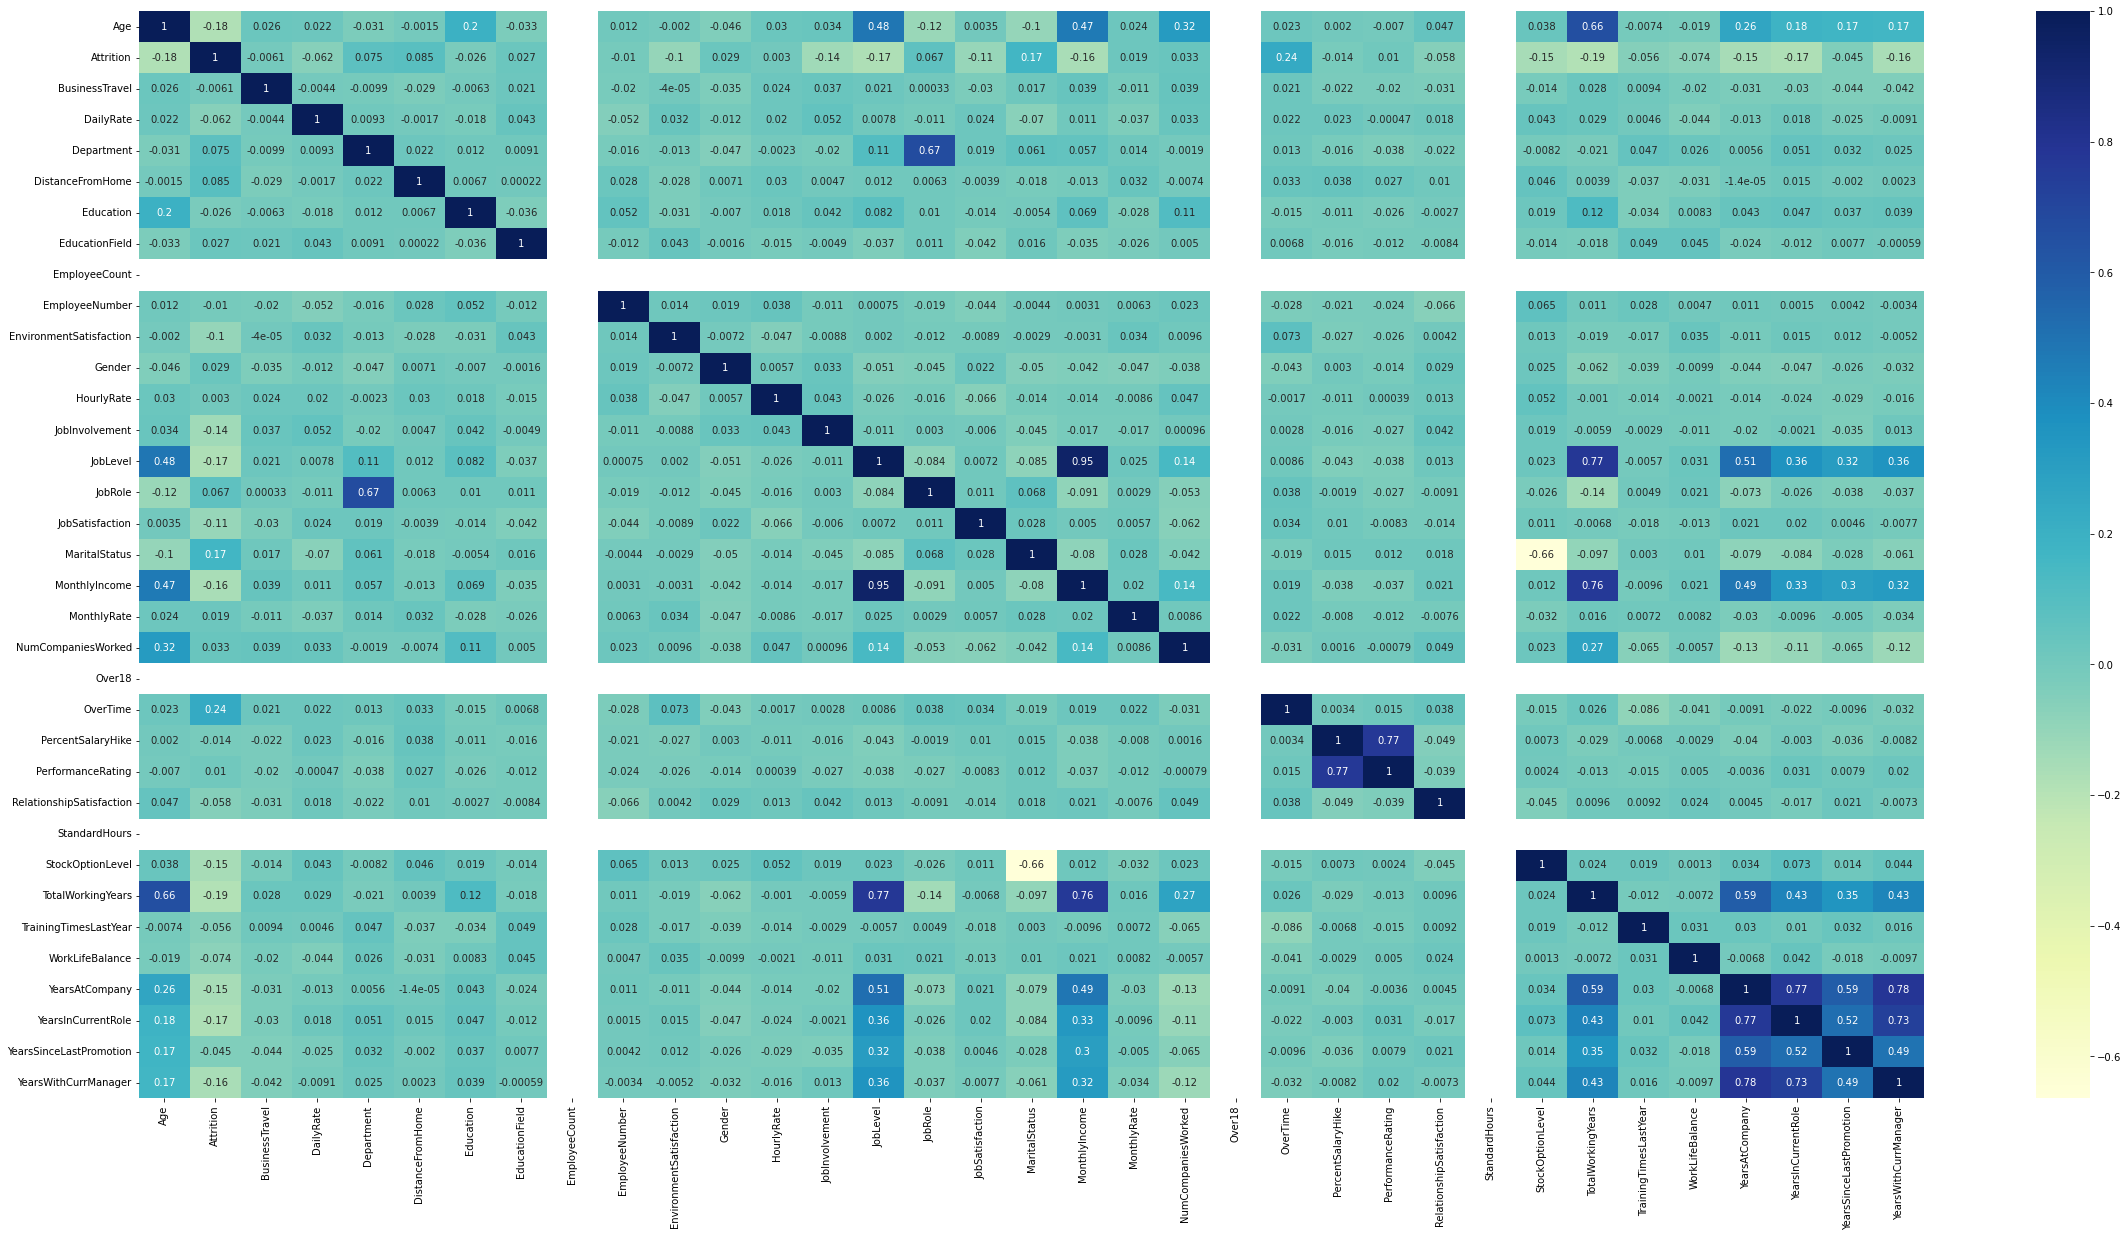

In [25]:
plt.figure(figsize = (40,20))
sns.heatmap(df.corr() , annot = True , cmap = "YlGnBu")

# Feature Selection

## less than 5% not accepted as a featur

In [26]:
round(abs(df.corr()['Attrition']*100).sort_values(ascending=False), 2)

Attrition                   100.00
OverTime                     23.74
TotalWorkingYears            18.54
Age                          17.65
JobLevel                     17.42
YearsInCurrentRole           17.33
MaritalStatus                16.68
MonthlyIncome                16.24
YearsWithCurrManager         15.71
YearsAtCompany               15.49
StockOptionLevel             15.40
JobInvolvement               13.64
JobSatisfaction              10.87
EnvironmentSatisfaction       9.95
DistanceFromHome              8.45
Department                    7.53
WorkLifeBalance               7.39
JobRole                       6.68
DailyRate                     6.15
RelationshipSatisfaction      5.82
TrainingTimesLastYear         5.60
YearsSinceLastPromotion       4.49
NumCompaniesWorked            3.28
Gender                        2.91
EducationField                2.66
Education                     2.59
MonthlyRate                   1.88
PercentSalaryHike             1.43
EmployeeNumber      

<AxesSubplot:>

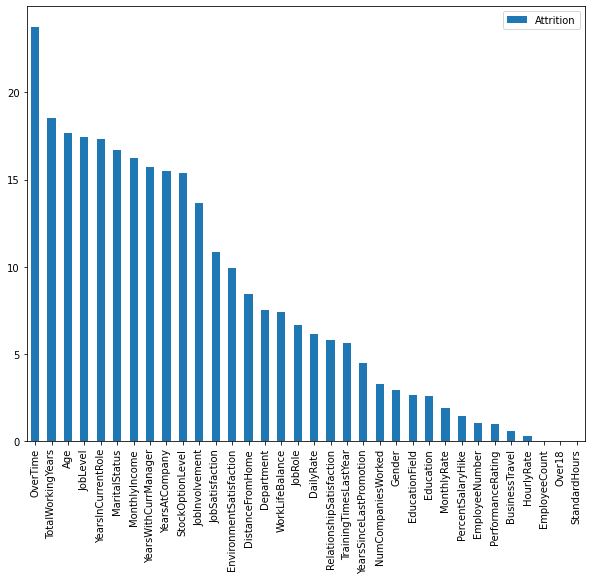

In [27]:
pd.DataFrame(abs(df.corr()['Attrition'].drop('Attrition')*100).sort_values(ascending=False)).plot.bar(figsize = (10,8))

In [28]:
mdf = df[['Attrition', 'OverTime',  'TotalWorkingYears',  'Age',  'JobLevel',  'YearsInCurrentRole',  'MaritalStatus',  'MonthlyIncome',  'YearsWithCurrManager',  'YearsAtCompany',  'StockOptionLevel',  'JobInvolvement',  'JobSatisfaction',  'EnvironmentSatisfaction',  'DistanceFromHome',  'Department',  'WorkLifeBalance',  'JobRole',  'DailyRate',  'RelationshipSatisfaction',  'TrainingTimesLastYear',]]
mdf

,Attrition,OverTime,TotalWorkingYears,Age,JobLevel,YearsInCurrentRole,MaritalStatus,MonthlyIncome,YearsWithCurrManager,YearsAtCompany,...,JobInvolvement,JobSatisfaction,EnvironmentSatisfaction,DistanceFromHome,Department,WorkLifeBalance,JobRole,DailyRate,RelationshipSatisfaction,TrainingTimesLastYear
0,1,1,8,41,2,4,2,5993,5,6,...,3,4,2,1,2,1,7,1102,1,0
1,0,0,10,49,2,7,1,5130,7,10,...,2,2,3,8,1,3,6,279,4,3
2,1,1,7,37,1,0,2,2090,0,0,...,2,3,4,2,1,3,2,1373,2,3
3,0,1,8,33,1,7,1,2909,0,8,...,3,3,4,3,1,3,6,1392,3,3
5,0,0,8,32,1,7,2,3068,6,7,...,3,4,4,2,1,2,2,1005,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0,0,17,36,2,2,1,2571,3,5,...,4,4,3,23,1,3,2,884,3,3
1466,0,0,9,39,3,7,1,9991,7,7,...,2,1,4,6,1,3,0,613,1,5
1467,0,1,6,27,2,2,1,6142,3,6,...,4,2,2,4,1,3,4,155,2,0
1468,0,0,17,49,2,6,1,5390,8,9,...,2,2,4,2,2,2,7,1023,4,3


# Imbalanced data

In [29]:
mdf['Attrition'].value_counts()

0    1164
1     221
Name: Attrition, dtype: int64

In [30]:
mdf.to_csv( './processed_data.csv')

In [31]:
mdf.head()

,Attrition,OverTime,TotalWorkingYears,Age,JobLevel,YearsInCurrentRole,MaritalStatus,MonthlyIncome,YearsWithCurrManager,YearsAtCompany,...,JobInvolvement,JobSatisfaction,EnvironmentSatisfaction,DistanceFromHome,Department,WorkLifeBalance,JobRole,DailyRate,RelationshipSatisfaction,TrainingTimesLastYear
0,1,1,8,41,2,4,2,5993,5,6,...,3,4,2,1,2,1,7,1102,1,0
1,0,0,10,49,2,7,1,5130,7,10,...,2,2,3,8,1,3,6,279,4,3
2,1,1,7,37,1,0,2,2090,0,0,...,2,3,4,2,1,3,2,1373,2,3
3,0,1,8,33,1,7,1,2909,0,8,...,3,3,4,3,1,3,6,1392,3,3
5,0,0,8,32,1,7,2,3068,6,7,...,3,4,4,2,1,2,2,1005,3,2


<AxesSubplot:ylabel='Attrition'>

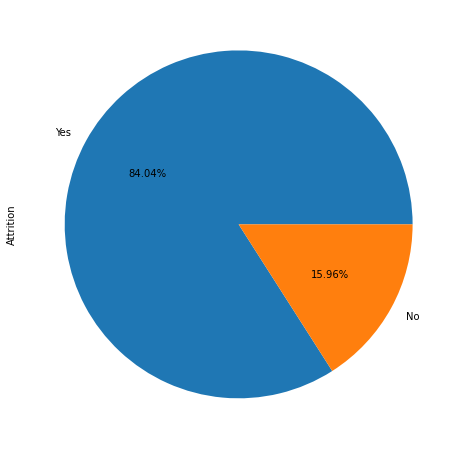

In [32]:
plt.figure(figsize=(12,8))
round(mdf['Attrition'].value_counts()/mdf.shape[0]*100, 2).plot.pie(autopct="%1.2f%%", labels=['Yes', 'No'])

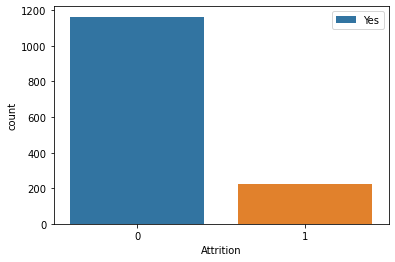

In [33]:
sns.countplot(data=mdf, x= 'Attrition')
plt.legend(labels=['Yes', 'No'])

# Modeling

In [34]:
x = mdf.drop(['Attrition'] , axis = 1).values
y = mdf['Attrition' ].values

# Split Data

In [35]:
x_train , x_test , y_train , y_test = train_test_split(x,y , test_size= 0.25 , random_state=42)
[x_train.shape, y_train.shape]

[(1038, 20), (1038,)]

# Data Scaling using Robust Scaler

In [36]:
ro_scaler = RobustScaler()
x_train = ro_scaler.fit_transform(x_train)
x_test = ro_scaler.fit_transform(x_test)
[x_train.shape, x_test.shape]

[(1038, 20), (347, 20)]

# Logistic Regression

In [37]:
lr = LogisticRegression(C = 100)

In [38]:
lr.fit(x_train , y_train)

LogisticRegression(C=100)

In [39]:
lr.score(x_train , y_train)

0.8853564547206165

In [40]:
lr.score(x_test , y_test)

0.8501440922190202

In [41]:
lr.coef_

array([[ 1.84669668, -0.33543611, -0.23758997, -0.20150696, -0.85416129,
         0.34102105, -0.39323716, -0.40667853,  0.50846514, -0.33072051,
        -0.52669192, -0.72810219, -0.77053935,  0.52282609,  0.98173566,
        -0.28317573, -0.59073193, -0.17205766, -0.41588281, -0.14633667]])

In [42]:
lr.intercept_

array([-3.65998423])

In [43]:
y_pred1 = lr.predict(x_test)
data = pd.DataFrame({"Y_test" : y_test , "y_pred1": y_pred1})
data.head(10)

,Y_test,y_pred1
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


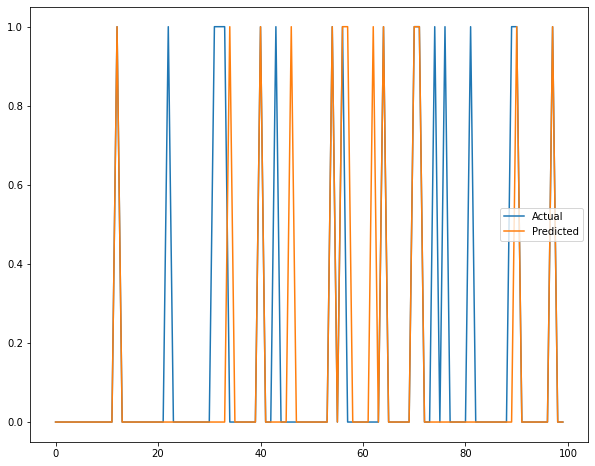

In [44]:
plt.figure(figsize=(10,8))
plt.plot(data[:100])
plt.legend(["Actual" , "Predicted"])

# Using Neural Network

In [45]:
df = pd.read_csv("./processed_data.csv", index_col=0)

In [46]:
df.head()

,Attrition,OverTime,TotalWorkingYears,Age,JobLevel,YearsInCurrentRole,MaritalStatus,MonthlyIncome,YearsWithCurrManager,YearsAtCompany,...,JobInvolvement,JobSatisfaction,EnvironmentSatisfaction,DistanceFromHome,Department,WorkLifeBalance,JobRole,DailyRate,RelationshipSatisfaction,TrainingTimesLastYear
0,1,1,8,41,2,4,2,5993,5,6,...,3,4,2,1,2,1,7,1102,1,0
1,0,0,10,49,2,7,1,5130,7,10,...,2,2,3,8,1,3,6,279,4,3
2,1,1,7,37,1,0,2,2090,0,0,...,2,3,4,2,1,3,2,1373,2,3
3,0,1,8,33,1,7,1,2909,0,8,...,3,3,4,3,1,3,6,1392,3,3
5,0,0,8,32,1,7,2,3068,6,7,...,3,4,4,2,1,2,2,1005,3,2


In [47]:
df.describe()

,Attrition,OverTime,TotalWorkingYears,Age,JobLevel,YearsInCurrentRole,MaritalStatus,MonthlyIncome,YearsWithCurrManager,YearsAtCompany,...,JobInvolvement,JobSatisfaction,EnvironmentSatisfaction,DistanceFromHome,Department,WorkLifeBalance,JobRole,DailyRate,RelationshipSatisfaction,TrainingTimesLastYear
count,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,...,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000
mean,0.159567,0.283755,10.792780,36.506859,2.015884,4.112635,1.096029,6270.006498,3.990614,6.677978,...,2.727076,2.736462,2.715523,9.206498,1.266426,2.758123,4.493141,802.807220,2.705415,2.812996
std,0.366336,0.450982,7.237084,8.937653,1.070374,3.516315,0.730344,4511.412367,3.375241,5.562596,...,0.718679,1.102680,1.092511,8.106362,0.527214,0.708113,2.478839,404.574635,1.080506,1.291526
min,0.000000,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000,1009.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,102.000000,1.000000,0.000000
25%,0.000000,0.000000,6.000000,30.000000,1.000000,2.000000,1.000000,2862.000000,2.000000,3.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,465.000000,2.000000,2.000000
50%,0.000000,0.000000,9.000000,35.000000,2.000000,3.000000,1.000000,4810.000000,3.000000,5.000000,...,3.000000,3.000000,3.000000,7.000000,1.000000,3.000000,5.000000,805.000000,3.000000,3.000000
75%,0.000000,1.000000,15.000000,42.000000,2.000000,7.000000,2.000000,7823.000000,7.000000,9.000000,...,3.000000,4.000000,4.000000,14.000000,2.000000,3.000000,7.000000,1162.000000,4.000000,3.000000
max,1.000000,1.000000,35.000000,60.000000,5.000000,17.000000,2.000000,19973.000000,15.000000,33.000000,...,4.000000,4.000000,4.000000,29.000000,2.000000,4.000000,8.000000,1499.000000,4.000000,6.000000


In [48]:
X = df.drop(['Attrition'] , axis = 1).values
Y = df['Attrition' ].values

In [49]:
x_train , x_test , y_train , y_test = train_test_split(X,Y , test_size= 0.25 , random_state=42)
[x_train.shape, y_train.shape]

[(1038, 20), (1038,)]

In [50]:
ro_scaler = RobustScaler()
x_train = ro_scaler.fit_transform(x_train)
x_test = ro_scaler.fit_transform(x_test)
[x_train.shape, x_test.shape]

[(1038, 20), (347, 20)]

In [51]:
X= ro_scaler.fit_transform(X)

In [52]:
X.shape

(1385, 20)

In [53]:
X_new = np.expand_dims(X, axis=2)

In [54]:
X_new.shape

(1385, 20, 1)

In [55]:
X_new[0].shape

(20, 1)

In [56]:
Y_new = np.expand_dims(Y, axis=1)

In [57]:
Y_new.shape

(1385, 1)

In [59]:
def get_nn_model():
    
    cnn_model=Sequential()
    cnn_model.add(tf.keras.layers.Dense(32, activation="relu",input_shape=(20,)))
    cnn_model.add(tf.keras.layers.Dense(256, activation="relu"))
    cnn_model.add(tf.keras.layers.Dropout(0.1))
    cnn_model.add(tf.keras.layers.Dense(4096, activation="relu"))
    predictions = cnn_model.add(tf.keras.layers.Dense(1, activation="sigmoid", name='classifier'))

    cnn_model.compile(loss='binary_crossentropy', optimizer='Adam',metrics=['accuracy'])
    # print(cnn_model.layers[0].output)
    return cnn_model

In [60]:
mymodel = get_nn_model()
mymodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                672       
                                                                 
 dense_1 (Dense)             (None, 256)               8448      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 4096)              1052672   
                                                                 
 classifier (Dense)          (None, 1)                 4097      
                                                                 
Total params: 1,065,889
Trainable params: 1,065,889
Non-trainable params: 0
_________________________________________________________________


In [61]:
from sklearn.model_selection import LeaveOneOut,KFold

In [62]:
tf.config.run_functions_eagerly(False)

In [63]:
mymodel.evaluate(X,Y,batch_size=16)

87/87 [==============================] - 4s 6ms/step - loss: 0.7095 - accuracy: 0.1856


[0.7095125913619995, 0.18555957078933716]

In [64]:
Y

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [65]:
mymodel.fit(X,Y, epochs=10, batch_size=32)

Epoch 1/10
44/44 [==============================] - 1s 15ms/step - loss: 0.4622 - accuracy: 0.8245
Epoch 2/10
44/44 [==============================] - 0s 10ms/step - loss: 0.3815 - accuracy: 0.8484
Epoch 3/10
44/44 [==============================] - 0s 10ms/step - loss: 0.3381 - accuracy: 0.8614
Epoch 4/10
44/44 [==============================] - 0s 10ms/step - loss: 0.3112 - accuracy: 0.8708
Epoch 5/10
44/44 [==============================] - 0s 10ms/step - loss: 0.2917 - accuracy: 0.8809
Epoch 6/10
44/44 [==============================] - 0s 10ms/step - loss: 0.2538 - accuracy: 0.8989
Epoch 7/10
44/44 [==============================] - 0s 10ms/step - loss: 0.2274 - accuracy: 0.9105
Epoch 8/10
44/44 [==============================] - 0s 10ms/step - loss: 0.1954 - accuracy: 0.9227
Epoch 9/10
44/44 [==============================] - 0s 10ms/step - loss: 0.1697 - accuracy: 0.9321
Epoch 10/10
44/44 [==============================] - 0s 10ms/step - loss: 0.1512 - accuracy: 0.9430


In [66]:
estimator = KerasClassifier(model=mymodel, epochs=5, batch_size=32, verbose=1)
kfold = KFold(n_splits=5, shuffle=True)
# kfold = LeaveOneOut()
results = cross_val_score(estimator, X_new, Y_new,cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

INFO:tensorflow:Assets written to: C:\Users\praka\AppData\Local\Temp\tmphc1zgszx\assets
Epoch 1/5
35/35 [==============================] - 1s 15ms/step - loss: 0.1356 - accuracy: 0.9486
Epoch 2/5
35/35 [==============================] - 0s 10ms/step - loss: 0.1082 - accuracy: 0.9576
Epoch 3/5
35/35 [==============================] - 0s 10ms/step - loss: 0.0958 - accuracy: 0.9594
Epoch 4/5
35/35 [==============================] - 0s 10ms/step - loss: 0.0674 - accuracy: 0.9756
Epoch 5/5
9/9 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: C:\Users\praka\AppData\Local\Temp\tmpcyzd0_fy\assets
Epoch 1/5
35/35 [==============================] - 1s 14ms/step - loss: 0.1250 - accuracy: 0.9495
Epoch 2/5
35/35 [==============================] - 0s 10ms/step - loss: 0.1013 - accuracy: 0.9612
Epoch 3/5
35/35 [==============================] - 0s 10ms/step - loss: 0.0883 - accuracy: 0.9702
Epoch 4/5
35/35 [==============================] - 0s 10ms/step - loss: 0.072

# 85% Accuracy with Logistic Regression

# 92.5% Accuracy with Neural Networks using Stratified KFold Validation